In [4]:
import simsz.make_dm_halo as make_dm_halo
import simsz.utils as utils
from simsz import simtools, noise, filters
import make_sz_cluster
import simsz.load_vars as load_vars
from colossus.halo import mass_adv
import matplotlib.pyplot as plt

import time
from datetime import datetime as dt
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import h5py
from pixell import enmap, powspec, enplot
import camb
#import healpy
import scipy

from astropy.constants import M_sun
from astropy.constants import G, sigma_T, m_e, c, h, k_B
from astropy import units as u

In [15]:
# # Set the size of the box in degrees and convert to radians to load in only part of these maps
dec_from, dec_to = np.deg2rad([-4,4])
ra_from, ra_to = np.deg2rad([-1, 45])

# # Create the box
box = [[dec_from,ra_from],[dec_to,ra_to]]

# # read in the map
# imap = enmap.read_map(path + "act_planck_dr5.01_s08s18_AA_f150_night_map.fits", box = box)[0]

img=enmap.read_map("act_dr5.01_s08s18_AA_f150_daynight_map.fits",box=box)[0]
ivar=enmap.read_map("act_dr5.01_s08s18_AA_f150_daynight_ivar.fits",box=box)[0]

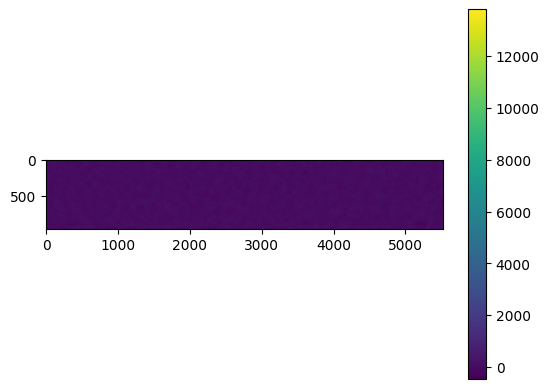

In [17]:
#This is the map
im=plt.imshow(img)
cbar = plt.colorbar(im)

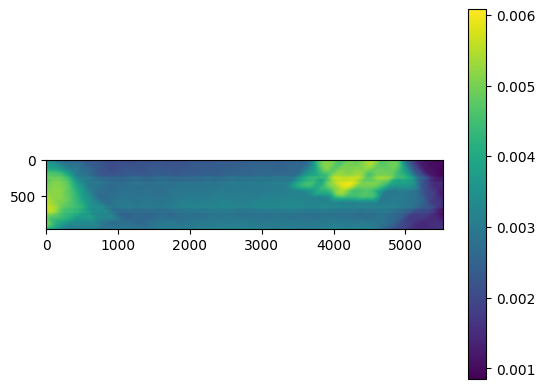

In [18]:
#This is the noise map
im2=plt.imshow(ivar)
cbar = plt.colorbar(im2)

In [53]:
def plotsubmap_w_radec(ra_in,dec_in): #Define a function to plot a submap
    dec,ra = np.deg2rad([dec_in,ra_in]) 
    # Give the box a width of 10 arcmin
    W = 0.325
    width = np.deg2rad(0.325)
    # Create the box and use it to select a submap
    box = [[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]]
    submap=img.submap(box)
    im3=plt.imshow(submap)
    cbar = plt.colorbar(im3)


In [74]:
#Make array of confirmed clusters for stacking from arXiv:1301.0816 (first 30)
rac=[2.0418,3.0152,3.7276,4.4138,4.5623,5.5553,6.5699,11.1076,11.3051,12.7875,14.5189,14.7855,16.2195,19.9971,21.8227,24.8407,28.1764,29.1008,31.5567,33.8699,34.5626,34.9533,34.9759,35.3925,35.7939,37.1250,37.7273,39.9718,40.0102,40.3129]
decc=[2.0204,-0.7693,-0.9502,-0.858,-0.3795,-0.605,1.3367,1.2221,-1.8827,0.9323,0.5106,-0.8326,0.0495,0.9193,0.3468,-1.4769,1.0059,-1.3879,-1.2428,0.5091,-0.6883,0.3755,1.4973,-0.2063,-0.9466,0.5033,-0.4043,-1.5758,1.2693,-0.3109]
zc=[0.36,1.36,0.533,0.211,0.75,0.805,0.65,1.11,0.545,0.69,0.76,0.786,0.277,0.72,0.379,0.70,0.230,0.45,0.676,0.865,0.672,0.537,0.35,0.589,0.663,0.72,0.44,0.375,0.62,0.684]
mc=[3.9,3.0,5.7,2.9,3.1,5.5,4.4,2.7,5.6,2.2,3.2,5.2,2.6,3.3,3.3,2.1,5.7,3.1,4.3,3.5,3.8,3.0,2.8,1.4,3.8,2.4,2.8,6.7,3.3,2.5]
mc=[x*1e14 for x in mc]





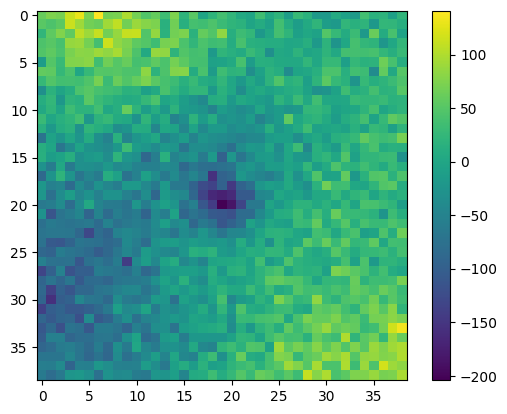

In [54]:
plotsubmap_w_radec(rac[5],decc[5]) #plot one of these confirm cluster submaps

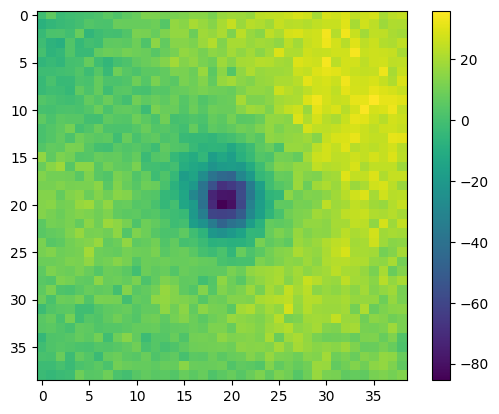

In [64]:
# Give the box a width of 19.5 arcmin 
W = 0.325
width = np.deg2rad(0.325)

for i in range(len(rac)): 
    dec,ra = np.deg2rad([decc[i],rac[i]]) 
    box = [[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]]
    submap=img.submap(box)
    if i==0:
        submaptot=submap
    if i>0:
        submaptot+=submap
    #print(np.shape(submap))

submaptot=submaptot/(len(rac))
im3=plt.imshow(submaptot)
cbar = plt.colorbar(im3)

#Plot a stack of these 30 clusters to compare to our sims. This is what the average map looks like:

Average in inner radius: -69.83549
Average in outer radius: -40.96874
tSZ signal: -28.866749


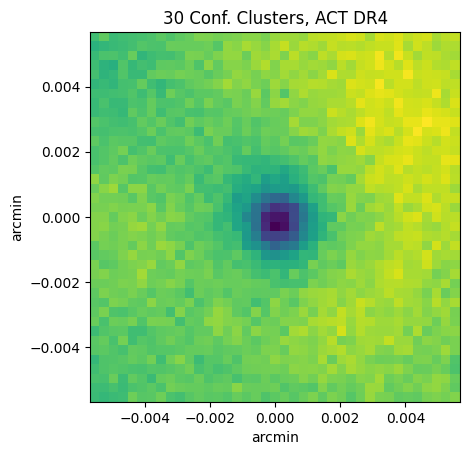

In [80]:
#Try AP on this stack. The circles are not plotting and I am not sure why

disk, ring, signal = filters.get_tSZ_signal_aperture_photometry(submaptot, 2.1)
print('Average in inner radius: '+str(disk))
print('Average in outer radius: '+str(ring))
print('tSZ signal: '+str(signal))
center = np.array(submaptot.shape) / 2
center = center - center[0]
fig, ax = plt.subplots()
ax.imshow(submaptot, extent=[-width,width,-width,width])
disk_circle = plt.Circle(center, 2.1, color='red', fill=False, linewidth=1)
annulus_circle = plt.Circle(center, 2.1 * np.sqrt(2), color='black', fill=False, linewidth=1)
ax.add_patch(disk_circle)
ax.add_patch(annulus_circle)
cbar = plt.colorbar(im, extend="max")
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('uK', rotation=270)
plt.title('30 Conf. Clusters, ACT DR4')
plt.show()

In [75]:
clusters = make_sz_cluster.simulate_submap(mc, zc) #Try a sim set of these masses and redshifts

#NOTE I generated these for UPP and want to try again with B12 estimates which are quite different

In [76]:
#Load the saved simset

filename='outfiles/sz_sim_230911172001791446_150_808298.h5'
f= h5py.File(filename)

keys=list(f.keys())

sims=[f[key]['final_map'] for key in keys]

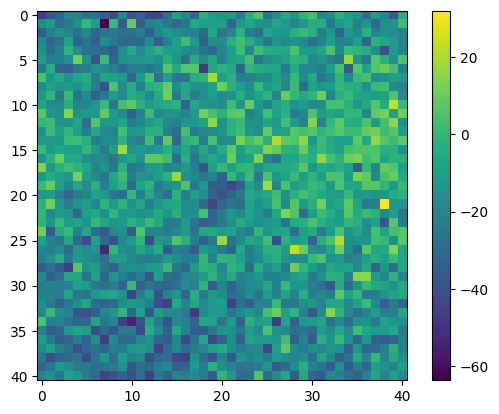

In [77]:
#Plot the stacked sims

simstot=np.zeros(np.shape(sims[0]))
for i in range(len(sims)):
    simstot+=sims[i]
    
simstot=simstot/(len(sims))
im3=plt.imshow(simstot)
cbar = plt.colorbar(im3)

Average in inner radius: -30.765673968707443
Average in outer radius: -17.453381778206413
tSZ signal: -13.31229219050103


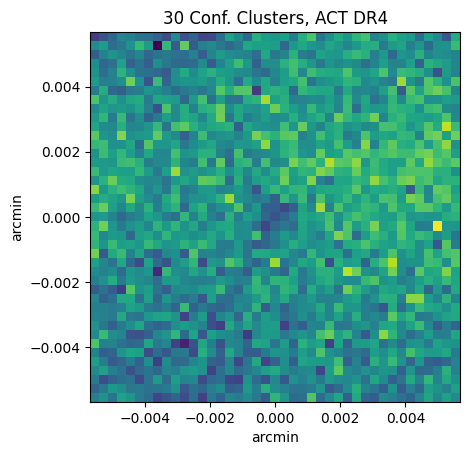

In [82]:
#Try AP on this stack. The circles are not plotting and I am not sure why

disk, ring, signal = filters.get_tSZ_signal_aperture_photometry(simstot, 2.1)
print('Average in inner radius: '+str(disk))
print('Average in outer radius: '+str(ring))
print('tSZ signal: '+str(signal))
center = np.array(simstot.shape) / 2
center = center - center[0]
fig, ax = plt.subplots()
ax.imshow(simstot, extent=[-width,width,-width,width])
disk_circle = plt.Circle(center, 2.1, color='red', fill=False, linewidth=1)
annulus_circle = plt.Circle(center, 2.1 * np.sqrt(2), color='black', fill=False, linewidth=1)
ax.add_patch(disk_circle)
ax.add_patch(annulus_circle)
cbar = plt.colorbar(im, extend="max")
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('uK', rotation=270)
plt.title('30 Conf. Clusters, ACT DR4')
plt.show()

To do: 
- Check noise in stacked ACT maps and noise inputs for sims 
- Change mass type and stack simulated clusters for B12 mass
- Fix circles in aperture photometry 